In [1]:
%matplotlib inline
import numpy as np
import pdb
import sklearn.metrics.pairwise as sk_distance
from sklearn.metrics import pairwise_distances
import matplotlib
#matplotlib.use('tkAgg')
import matplotlib.pyplot as plt
import glob
import sys
from matplotlib.ticker import MultipleLocator
import math
from scipy.spatial import distance
from joblib import Parallel, delayed
from joblib import parallel_backend
import os
usable_cores = os.sched_getaffinity(0)
import time
import json
# os.system("taskset -p 0xff %d" % os.getpid())

In [2]:
def part1(x, y):
    result = 0
    for xi, yi in zip(x, y):
        result += max((xi - yi), 0)
    return result
def part2(x, y):
    result = 0
    for xi, yi in zip(x, y):
        result += max(-(xi - yi), 0)
    return result

def all_distance(x, y, metric):
    if metric == 'euclid':
        return distance.euclidean(x, y)
    elif metric == 'cosine':
        return distance.cosine(x, y)
    elif metric == 'd1':
        return math.sqrt(part1(x, y) ** 2 + part2(x, y) ** 2)
    elif metric == 'd2':
        top = math.sqrt(part1(x, y) ** 2 + part2(x, y) ** 2)
        bottom = 0
        for xi, yi in zip(x, y):
            bottom += max(abs(xi), abs(yi), abs(xi-yi))
        return top / bottom
    
def euclid_distance(x, y):
    result = 0
    for xi, yi in zip(x, y):
        result += (xi - yi) ** 2
    return math.sqrt(result)

def d1_distance(x, y):
    return math.sqrt(part1(x, y) ** 2 + part2(x, y) ** 2)

# def d1_distance(x, y):
# #     part1 = np.sum(x-y, where=(x-y>0))
# #     part2 = np.sum(-(x - y), where=(-(x - y)>0))
#     result = x-y
#     part1 = np.sum(result[result>0])
#     part2 = np.sum(-result[-result>0])
#     return math.sqrt(part1 ** 2 + part2 ** 2)

def d2_distance_bottom(x, y):
    bottom = 0
    for xi, yi in zip(x, y):
        bottom += max(abs(xi), abs(yi), abs(xi-yi))
    return bottom

def gen_input(d, distr, n=10000):
    D = []        
    if distr == 'uniform':
        for i in range(n):
            D.append(np.random.uniform(size=d))
        return D
    elif distr == 'gaussian':
        for i in range(n):
            D.append(np.random.normal(0, 1, size=d))
        return D

class Row:
    def __init__(self, i, value):
        self.j = i
        self.value = value
        
def matrix_loop(i, dis):
    row = []
    for j in range(lenD):
        row.append(all_distance(Di, D[j], dis))
    result = Row(i, row)
    return result

3, uniform, euclid
3, uniform, cosine
3, gaussian, euclid
3, gaussian, cosine
30, uniform, euclid
30, uniform, cosine
30, gaussian, euclid
30, gaussian, cosine


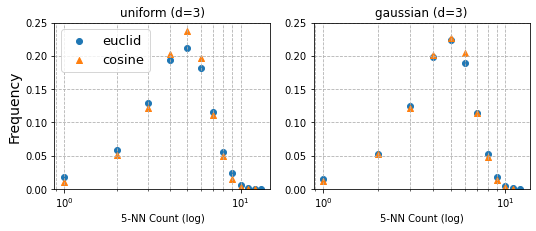

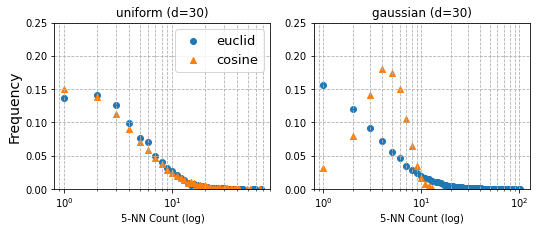

In [3]:
distances = ['euclid', 'cosine', 'custom1', 'custom2']
total_points = [10000, 10000, 2000, 2000]
distrs = ['uniform', 'gaussian']
ds = [300]#, 3000] 
markers = ['o', '^', 'D', 'p']

for d in ds:
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 0.1, 'wspace': 0.2, 'bottom': 0.13, 
                                           'top': 0.9, 'right':0.995, 'left':0.17}, figsize=(8,3))
    axs[0].set_ylabel('Frequency', fontsize=14)
    outlier_dict = {}
    for ax in axs:
        ax.set_xlabel('5-NN Count (log)')
        ax.grid(which='both', axis='both', ls='dashed')
        ax.set_ylim(0,0.25)
#         ax.xaxis.set_major_locator(MultipleLocator(1))
    for m, distr in enumerate(distrs):
        outlier_dict[distr] = {}
        axs[m].set_title(f'{distr} (d={d})')        
        D_all = gen_input(d, distr, n=10000)      
        for n, dis in enumerate(distances):
            total = total_points[n]
            D = D_all[:total]
            
            if dis == 'euclid': 
                dis_matrix = sk_distance.euclidean_distances(D)                                 
            elif dis == 'cosine':
                dis_matrix = sk_distance.cosine_distances(D) 
            elif dis == 'custom1': #TODO: test if this backend is working
                with parallel_backend(backend='loky', n_jobs=len(usable_cores)):         
                    dis_matrix = pairwise_distances(D, metric=d1_distance)
                    dis_matrix_bottom = pairwise_distances(D, metric=d2_distance_bottom)                    
            elif dis == 'custom2':
                with parallel_backend(backend='loky', n_jobs=len(usable_cores)):
                    dis_matrix = dis_matrix / dis_matrix_bottom
                
                # generate 10000x10000 distance matrix        
#                 dis_matrix = np.empty((len(D), len(D)))
#                 for i in range(len(D)):
#                     for j in range(len(D)):
#                         dis_matrix[i, j] = all_distance(D[i], D[j], dis)
            
            # for each point, find its 5 nearest neighbor, increment the values
            nn_array = np.zeros(len(D))
            for i, point in enumerate(D):
                row = dis_matrix[i]
                nn = np.argpartition(row, 6)[:6] # 5NN, but self is included in row            
                for index in nn:
                    if index != i:
                        nn_array[index] += 1
            
            # generate histogram
            x, y = np.unique(nn_array, return_counts=True)            
            outlier = sum(y[:5]) / total * 100
            outlier_dict[distr][dis] = outlier
            axs[m].scatter(x, y/total, label=dis, marker=markers[n])
            axs[m].set_xscale('log')
            print(f'{d}, {distr}, {dis}')
    with open(f'jsons/d{d}.json', 'w') as f:
        json.dump(outlier_dict, f, indent=4)
    axs[0].legend(fontsize=13)
    fig.savefig(f'plots/d{d}.png', bbox_inches='tight')
        